In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import warnings
warnings.filterwarnings('ignore')

# Loading data

In [2]:
dfParticipants = pd.read_csv("R-SED_data/participants.csv", delimiter=",", index_col=0)

In [3]:
dfJudgements = pd.read_csv("R-SED_data/triplet_judgements.csv", delimiter=",", index_col=0)

In [4]:
dfTriplets = pd.read_csv("R-SED_data/triplets.csv", delimiter=",", index_col=0)

In [5]:
dfAll = dfParticipants.join(dfJudgements.reset_index().set_index("user_id"), how="inner")
dfAll = dfAll.reset_index().set_index("triplet_id").join(dfTriplets, how="inner").reset_index().set_index("judgement_id")
dfAll.head(3)

,triplet_id,user_id,age_group,education,ml_expert,choice,simplified_choice,option_one_path,option_two_path,time_spent,handheld,window_width,window_height,user_agent,model,target_path,candidate1_path,candidate2_path,candidate1_bin,candidate2_bin,W2VVExtractor_cosdist_query_candidate1,W2VVExtractor_cosdist_query_candidate2,W2VVExtractor_cosdist_candidates,W2VVExtractor_eucldist_query_candidate1,W2VVExtractor_eucldist_query_candidate2,W2VVExtractor_eucldist_candidates,CIELABPositionalExctractor_regions_2x2_cosdist_query_candidate1,CIELABPositionalExctractor_regions_2x2_cosdist_query_candidate2,CIELABPositionalExctractor_regions_2x2_cosdist_candidates,CIELABPositionalExctractor_regions_2x2_eucldist_query_candidate1,CIELABPositionalExctractor_regions_2x2_eucldist_query_candidate2,CIELABPositionalExctractor_regions_2x2_eucldist_candidates,VLADExctractor__cosdist_query_candidate1,VLADExctractor__cosdist_query_candidate2,VLADExctractor__cosdist_candidates,VLADExctractor__eucldist_query_candidate1,VLADExctractor__eucldist_query_candidate2,VLADExctractor__eucldist_candidates,RGBHistogramExtractor_256_cosdist_query_candidate1,RGBHistogramExtractor_256_cosdist_query_candidate2,RGBHistogramExtractor_256_cosdist_candidates,RGBHistogramExtractor_256_eucldist_query_candidate1,RGBHistogramExtractor_256_eucldist_query_candidate2,RGBHistogramExtractor_256_eucldist_candidates,ConvNeXTExtractor_tiny_cosdist_query_candidate1,ConvNeXTExtractor_tiny_cosdist_query_candidate2,ConvNeXTExtractor_tiny_cosdist_candidates,ConvNeXTExtractor_tiny_eucldist_query_candidate1,ConvNeXTExtractor_tiny_eucldist_query_candidate2,ConvNeXTExtractor_tiny_eucldist_candidates,ViTExtractor_base_cosdist_query_candidate1,ViTExtractor_base_cosdist_query_candidate2,ViTExtractor_base_cosdist_candidates,ViTExtractor_base_eucldist_query_candidate1,ViTExtractor_base_eucldist_query_candidate2,ViTExtractor_base_eucldist_candidates,EfficientNetExtractor_0_cosdist_query_candidate1,EfficientNetExtractor_0_cosdist_query_candidate2,EfficientNetExtractor_0_cosdist_candidates,EfficientNetExtractor_0_eucldist_query_candidate1,EfficientNetExtractor_0_eucldist_query_candidate2,EfficientNetExtractor_0_eucldist_candidates,ConvNeXTExtractor_small_cosdist_query_candidate1,ConvNeXTExtractor_small_cosdist_query_candidate2,ConvNeXTExtractor_small_cosdist_candidates,ConvNeXTExtractor_small_eucldist_query_candidate1,ConvNeXTExtractor_small_eucldist_query_candidate2,ConvNeXTExtractor_small_eucldist_candidates,CIELABPositionalExctractor_regions_4x4_cosdist_query_candidate1,CIELABPositionalExctractor_regions_4x4_cosdist_query_candidate2,CIELABPositionalExctractor_regions_4x4_cosdist_candidates,CIELABPositionalExctractor_regions_4x4_eucldist_query_candidate1,CIELABPositionalExctractor_regions_4x4_eucldist_query_candidate2,CIELABPositionalExctractor_regions_4x4_eucldist_candidates,EfficientNetExtractor_4_cosdist_query_candidate1,EfficientNetExtractor_4_cosdist_query_candidate2,EfficientNetExtractor_4_cosdist_candidates,EfficientNetExtractor_4_eucldist_query_candidate1,EfficientNetExtractor_4_eucldist_query_candidate2,EfficientNetExtractor_4_eucldist_candidates,ConvNeXTExtractor_base_cosdist_query_candidate1,ConvNeXTExtractor_base_cosdist_query_candidate2,ConvNeXTExtractor_base_cosdist_candidates,ConvNeXTExtractor_base_eucldist_query_candidate1,ConvNeXTExtractor_base_eucldist_query_candidate2,ConvNeXTExtractor_base_eucldist_candidates,RGBHistogramExtractor_64_cosdist_query_candidate1,RGBHistogramExtractor_64_cosdist_query_candidate2,RGBHistogramExtractor_64_cosdist_candidates,RGBHistogramExtractor_64_eucldist_query_candidate1,RGBHistogramExtractor_64_eucldist_query_candidate2,RGBHistogramExtractor_64_eucldist_candidates,CLIPExtractor_medium_cosdist_query_candidate1,CLIPExtractor_medium_cosdist_query_candidate2,CLIPExtractor_medium_cosdist_candidates,CLIPExtractor_medium_eucldist_query_candidate1,CLIPExtractor_medium_eucldist_query_candidate2,CLIPExtractor_medium_eucldist_candidates,VANExtractor_base_cosdist_

# Divide judgements by the dataset
- general vs. wedding vs. scuba

## Simplified judgement analysis
- focusing only on whether left or right choice was more similar
- ignoring indifferent judgements as well as magnitude of user's judgement
- analysis is limited to cosine distance

In [6]:
extractors = dfAll.model.unique()
extractors.sort()
dfAll["candidate1DisplayedOnLeft"] = (dfAll["option_one_path"] == dfAll["candidate1_path"])
columnsToDrop = []
for extractor in extractors:
    col1 = extractor+"_cosdist_query_candidate1"
    col2 = extractor+"_cosdist_query_candidate2"
    col1e = extractor+"_eucldist_query_candidate1"
    col2e = extractor+"_eucldist_query_candidate2"
    opt = extractor+"_eucldist_candidates"
    #dealing with the fact that either of candidate1 and candidate2 can be displayed as left/right option
    dfAll[extractor+"_option_left_dist"] = dfAll[col2]
    dfAll[extractor+"_option_right_dist"] = dfAll[col1]
    dfAll.loc[dfAll["candidate1DisplayedOnLeft"],extractor+"_option_left_dist"] = dfAll[col1]
    dfAll.loc[dfAll["candidate1DisplayedOnLeft"],extractor+"_option_right_dist"] = dfAll[col2]
    
    #assessing consistency of the model with human judgement
    right_option_better = ((dfAll[extractor+"_option_left_dist"] > dfAll[extractor+"_option_right_dist"]))
    dfAll["better_for_"+extractor] = right_option_better.astype(int) * 2 - 1
    
    dfAll["same_as_model_"+extractor] = dfAll["simplified_choice"] == dfAll["better_for_"+extractor]
    
    #cleaning the data frame
    columnsToDrop.extend([col1,col2,col1e,col2e,opt])    
dfConsistency = dfAll.drop(columnsToDrop,axis=1)   
dfConsistencyNonUnknown = dfConsistency.loc[dfConsistency.simplified_choice!=0]

In [7]:
dfGeneral = dfConsistencyNonUnknown.loc[dfConsistencyNonUnknown["class"]=="general"]
dfWedding = dfConsistencyNonUnknown.loc[dfConsistencyNonUnknown["class"]=="wedding"]
dfScuba = dfConsistencyNonUnknown.loc[dfConsistencyNonUnknown["class"]=="scuba"]

dfGeneral.shape, dfWedding.shape, dfScuba.shape

((6612, 172), (3719, 172), (3732, 172))

## Evaluation variant 1: all user judgement decisions count equally

In [8]:
def scoreCounting(df):
    extrNames = []
    scores = []
    for extractor in extractors:
        name = "same_as_model_"+extractor
        extrNames.extend([extractor]*df.shape[0])
        scores.extend(df[name].values.tolist())  
    dfScores = pd.DataFrame({"Extractor":extrNames,"consistent":scores})
    return(dfScores)

In [9]:
dfScoresGeneral = scoreCounting(dfGeneral)
dfScoresWedding = scoreCounting(dfWedding)
dfScoresScuba = scoreCounting(dfScuba)
dfScores = scoreCounting(dfConsistencyNonUnknown)

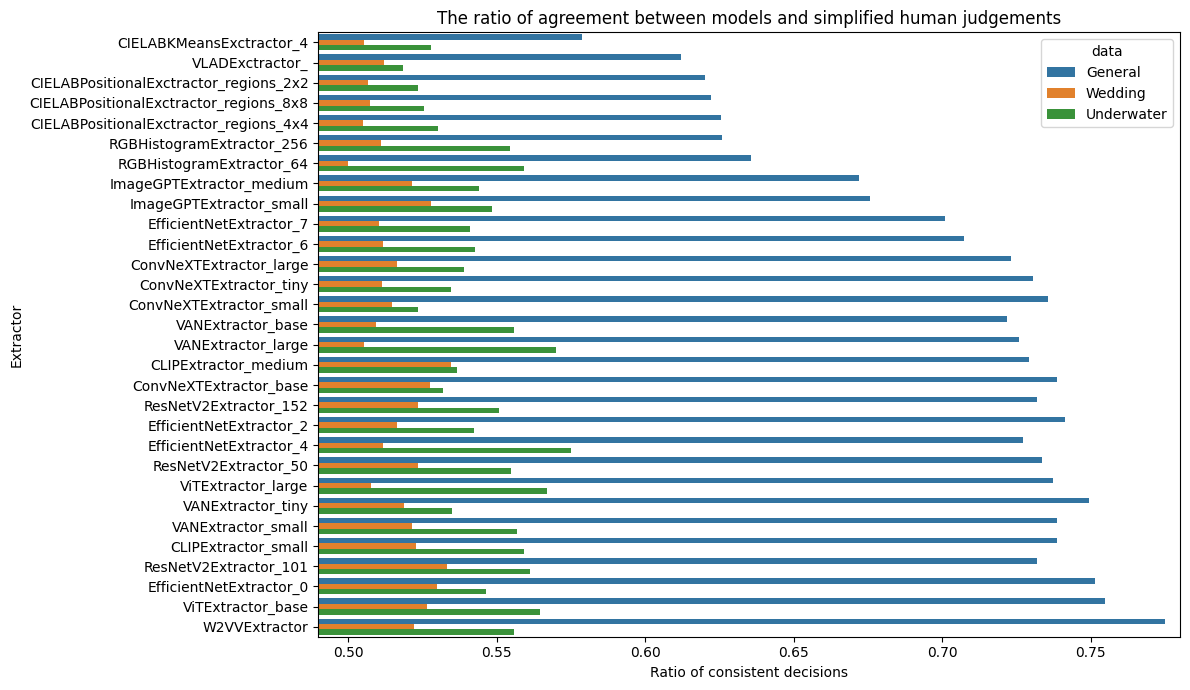

In [10]:
dfScoresGeneral["data"] = "General"
dfScoresWedding["data"] = "Wedding"
dfScoresScuba["data"] = "Underwater"
dfScoresBoth = pd.concat([dfScoresGeneral,dfScoresWedding,dfScoresScuba])
plt.title("The ratio of agreement between models and simplified human judgements")
sns.barplot(data = dfScoresBoth
            ,x="consistent",y="Extractor"
            , order=dfScores.groupby("Extractor")["consistent"].sum().sort_values().index
            , hue="data"
            , errorbar=None)

fig = plt.gcf()
fig.set_size_inches(12, 7)

ax = plt.gca()
ax.set_xlabel("Ratio of consistent decisions")
ax.set_xlim(0.49,0.78)

plt.tight_layout()

Notable observations:
- much lower consistency for both subclasses than for general (understandable due to compactness of the subdomains)
- considerable differences in ordering of best methods

In [11]:
dfMeanScores = dfScoresBoth.groupby(["data","Extractor"]).mean().reset_index()
dfMeanScores.pivot(index="Extractor", columns="data", values="consistent").corr()

data,General,Underwater,Wedding
data,,,
General,1.000000,0.469605,0.570683
Underwater,0.469605,1.000000,0.127702
Wedding,0.570683,0.127702,1.000000


In [12]:
dfMeanScores.pivot(index="Extractor", columns="data", values="consistent").corr("spearman")

data,General,Underwater,Wedding
data,,,
General,1.000000,0.397841,0.606010
Underwater,0.397841,1.000000,0.145131
Wedding,0.606010,0.145131,1.000000


- further illustrated via quite low values of correlation between consistency values
- highly different ordering of extractors consistency especially while comparing  both sub-domains

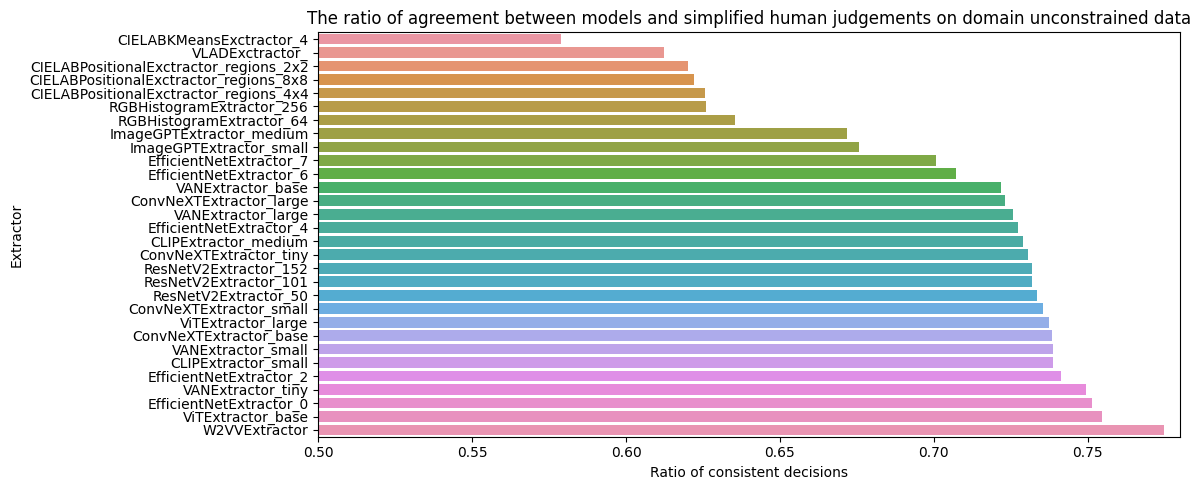

In [13]:
plt.title("The ratio of agreement between models and simplified human judgements on domain unconstrained data")
sns.barplot(data = dfScoresGeneral
            ,x="consistent",y="Extractor"
            , order=dfScoresGeneral.groupby("Extractor")["consistent"].sum().sort_values().index
            , errorbar=None)

fig = plt.gcf()
fig.set_size_inches(12, 5)

ax = plt.gca()
ax.set_xlabel("Ratio of consistent decisions")
ax.set_xlim(0.50,0.78)

plt.tight_layout()
plt.savefig("img/general_consistentRatio.pdf")
plt.show()

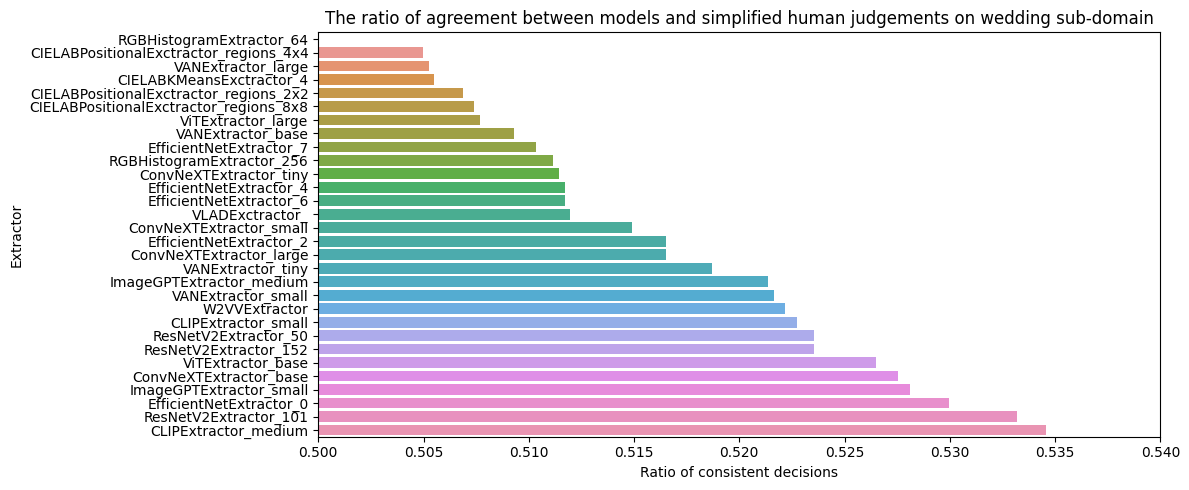

In [14]:
plt.title("The ratio of agreement between models and simplified human judgements on wedding sub-domain")
sns.barplot(data = dfScoresWedding
            ,x="consistent",y="Extractor"
            , order=dfScoresWedding.groupby("Extractor")["consistent"].sum().sort_values().index
            , errorbar=None)

fig = plt.gcf()
fig.set_size_inches(12, 5)

ax = plt.gca()
ax.set_xlabel("Ratio of consistent decisions")
ax.set_xlim(0.50,0.54)

plt.tight_layout()
plt.savefig("img/wedding_consistentRatio.pdf")
plt.show()

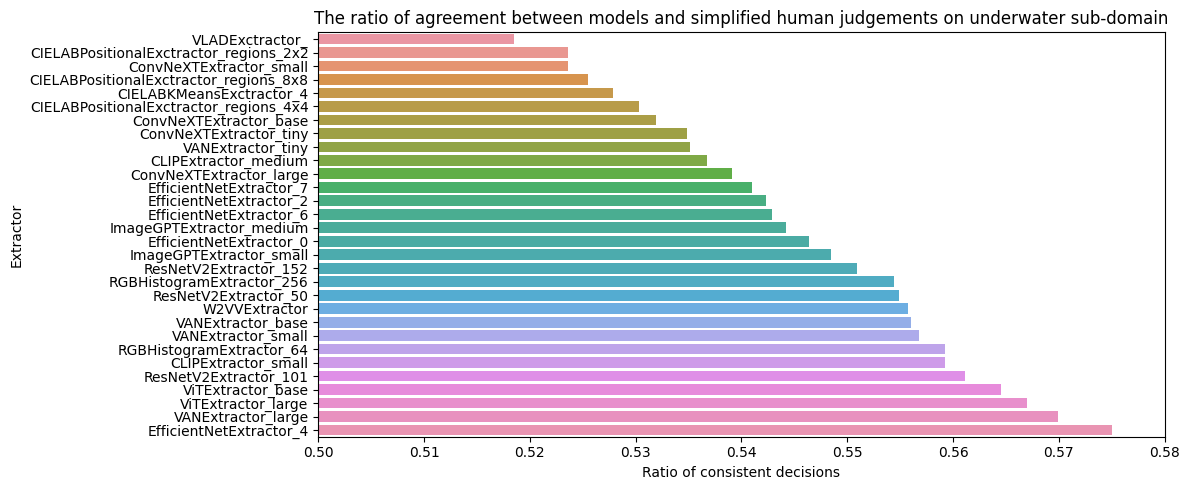

In [15]:
plt.figure(figsize=(15,6))
plt.title("The ratio of agreement between models and simplified human judgements on underwater sub-domain")
sns.barplot(data = dfScoresScuba
            ,x="consistent",y="Extractor"
            , order=dfScoresScuba.groupby("Extractor")["consistent"].sum().sort_values().index
            , errorbar=None)

fig = plt.gcf()
fig.set_size_inches(12, 5)

ax = plt.gca()
ax.set_xlabel("Ratio of consistent decisions")
ax.set_xlim(0.50,0.58)

plt.tight_layout()
plt.savefig("img/scuba_consistentRatio.pdf")
plt.show()

Notable points:
- almost completely different ordering of best methods
    - e.g., none of the extractors scored in top-3 for all cases
- good performance of RGBHistogram on scuba diving videos

# Correlation with detailed judgements
- judgements are considered as numeric values from -2 to +2 corresponding to a 5-point likert scale
- models are treated w.r.t. difference in the distance of respective candidates

In [16]:
dfAll["candidate1_preference"] = 0
dfAll.loc[dfAll.candidate1DisplayedOnLeft, "candidate1_preference"] = -dfAll.choice
dfAll.loc[~dfAll.candidate1DisplayedOnLeft, "candidate1_preference"] = dfAll.choice
#positive values indicate that users prefered candidate1 as more similar to query

In [17]:
columnsToDrop = []
minDistance = 1e-5
for extractor in extractors:
    col1 = extractor+"_cosdist_query_candidate1"
    col2 = extractor+"_cosdist_query_candidate2"
    opts = extractor+"_cosdist_candidates"
    dfAll.loc[dfAll[opts]==0,opts] = minDistance # fixing division by zero
    
    #positive values indicate that candidate1 is more similar than candidate2 (i.e., had lower distance)
    dfAll["distance_diff_"+extractor] = (dfAll[col2] - dfAll[col1])
    dfAll["distance_diff_maxNorm"+extractor] = (dfAll[col2] - dfAll[col1])/dfAll[[col1, col2]].max(axis=1)
    dfAll["distance_diff_optionsDiffNorm"+extractor] = (dfAll[col2] - dfAll[col1])/dfAll[opts]

In [18]:
dfGeneral = dfAll.loc[dfAll["class"]=="general"]
dfWedding = dfAll.loc[dfAll["class"]=="wedding"]
dfScuba = dfAll.loc[dfAll["class"]=="scuba"]

In [19]:
from scipy.stats import pearsonr, spearmanr
def correlationCalculation(df):
    resultsDistanceDiff = {}
    resultsDistanceDiffNorm = {}
    resultsDistanceDiffOptNorm = {}

    for extractor in extractors:
        resultsDistanceDiff[extractor] = pearsonr(df["distance_diff_"+extractor],df["candidate1_preference"])[0]
        resultsDistanceDiffNorm[extractor] = pearsonr(df["distance_diff_maxNorm"+extractor],df["candidate1_preference"])[0]
        resultsDistanceDiffOptNorm[extractor] = pearsonr(df["distance_diff_optionsDiffNorm"+extractor],df["candidate1_preference"])[0]

    dfPearsonCorrelationResults = pd.DataFrame([resultsDistanceDiff,resultsDistanceDiffNorm,resultsDistanceDiffOptNorm],index=["distanceDiff","maxNormalizedDistanceDiff","optionsDistanceNormalizedDiff"]).T
    return dfPearsonCorrelationResults

In [24]:
dfCorrOverall = correlationCalculation(dfAll)

In [20]:
dfCorrGeneral = correlationCalculation(dfGeneral)
dfCorrGeneral

,distanceDiff,maxNormalizedDistanceDiff,optionsDistanceNormalizedDiff
CIELABKMeansExctractor_4,0.158840,0.183101,0.128255
CIELABPositionalExctractor_regions_2x2,0.162430,0.227990,0.138925
CIELABPositionalExctractor_regions_4x4,0.191691,0.265731,0.195339
CIELABPositionalExctractor_regions_8x8,0.206281,0.274090,0.208673
CLIPExtractor_medium,0.411973,0.489662,0.460279
CLIPExtractor_small,0.399105,0.474670,0.444482
ConvNeXTExtractor_base,0.510714,0.521833,0.514519
ConvNeXTExtractor_large,0.491126,0.493093,0.488072
ConvNeXTExtractor_small,0.500968,0.514608,0.504262
ConvNeXTExtractor_tiny,0.500260,0.507307,0.494272


Quite expected, correlations for general domain are much higher than the overall ones

In [21]:
dfCorrWedding = correlationCalculation(dfWedding)
dfCorrWedding

,distanceDiff,maxNormalizedDistanceDiff,optionsDistanceNormalizedDiff
CIELABKMeansExctractor_4,0.035188,0.042501,-0.002135
CIELABPositionalExctractor_regions_2x2,0.039713,0.027131,-0.019336
CIELABPositionalExctractor_regions_4x4,0.049513,0.038584,0.025452
CIELABPositionalExctractor_regions_8x8,0.054204,0.049203,0.040039
CLIPExtractor_medium,0.062543,0.088864,0.046524
CLIPExtractor_small,0.057867,0.077338,0.051186
ConvNeXTExtractor_base,0.109061,0.107321,0.099292
ConvNeXTExtractor_large,0.122113,0.119046,0.115856
ConvNeXTExtractor_small,0.118975,0.118066,0.106945
ConvNeXTExtractor_tiny,0.108707,0.108014,0.106935


In contrast, close to zero correlations for wedding videos

In [22]:
dfCorrScuba = correlationCalculation(dfScuba)
dfCorrScuba

,distanceDiff,maxNormalizedDistanceDiff,optionsDistanceNormalizedDiff
CIELABKMeansExctractor_4,0.061393,0.062694,0.065159
CIELABPositionalExctractor_regions_2x2,0.033015,0.056601,0.054128
CIELABPositionalExctractor_regions_4x4,0.054653,0.080676,0.083997
CIELABPositionalExctractor_regions_8x8,0.066018,0.083161,0.086418
CLIPExtractor_medium,0.126425,0.136889,0.124117
CLIPExtractor_small,0.129945,0.136601,0.115739
ConvNeXTExtractor_base,0.144846,0.144834,0.134308
ConvNeXTExtractor_large,0.150526,0.147615,0.144538
ConvNeXTExtractor_small,0.140163,0.140785,0.130951
ConvNeXTExtractor_tiny,0.138320,0.138447,0.131590


Slightly higher values for underwater videos, but still on the edge of very low correlation even for the best methods

## Correlations with models as well as all data segments

In [23]:
cnames=[]
for extractor in extractors:
    cnames.append("distance_diff_maxNorm"+extractor)
dfModelsDistanceDiff = dfAll[cnames]
dfModelsDistanceDiff.shape

(17026, 30)

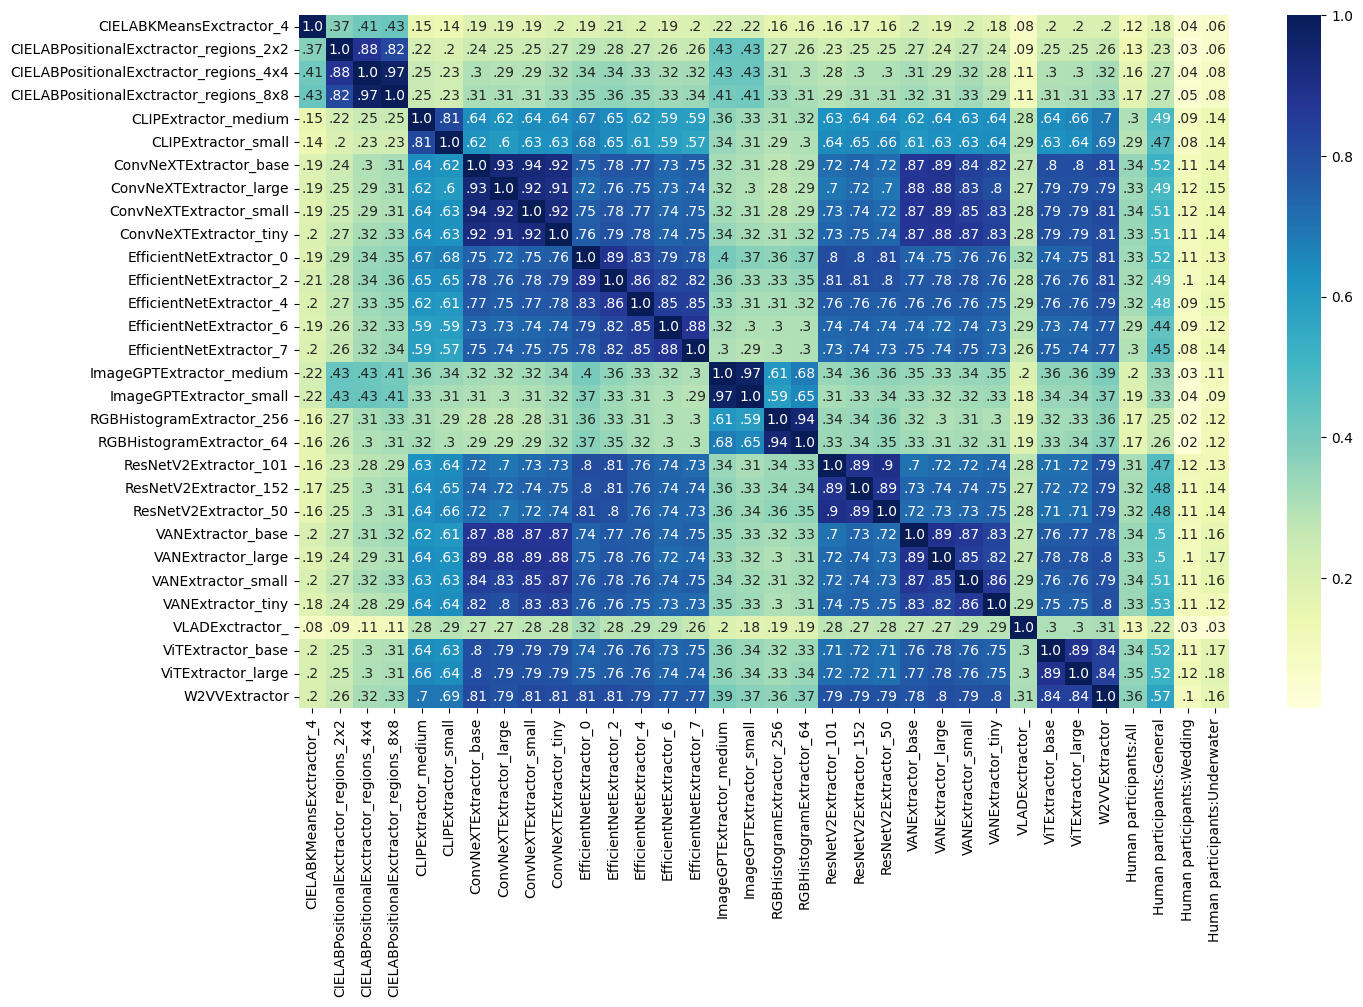

In [25]:
corrDF = dfModelsDistanceDiff.corr()
corrDF.columns = corrDF.columns.str.replace("distance_diff_maxNorm","")
corrDF.index = corrDF.index.str.replace("distance_diff_maxNorm","")
corrDF["Human participants:All "] = dfCorrOverall["maxNormalizedDistanceDiff"]
corrDF["Human participants:General"] = dfCorrGeneral["maxNormalizedDistanceDiff"]
corrDF["Human participants:Wedding"] = dfCorrWedding["maxNormalizedDistanceDiff"]
corrDF["Human participants:Underwater"] = dfCorrScuba["maxNormalizedDistanceDiff"]

annot_arr = np.around(corrDF.values,2).astype('str')
annot_arr = np.char.replace(annot_arr,"0.",".")
plt.figure(figsize=(15,9))
sns.heatmap(corrDF,  cmap="YlGnBu", annot=annot_arr, fmt="s")
plt.savefig("overall_correlationmatrix.pdf")